In [17]:
import datetime
import numpy as np
import pandas as pd
from collections import namedtuple
from dataclasses import dataclass
from IPython.display import clear_output
import matplotlib.pyplot as plt
from collections import defaultdict

## Packages
The requirements are:
- pandas
- matplotlib

## I/O related routines

In [121]:
def write_out_results(report_file, hyper_params, bestsol, tag=""):
    """Writes out the results to a csv file for later reference"""
    with open(report_file, "a+") as out:
        cost = f"{bestsol.cost}:6.2f"
        costs = ",".join([f"{p}" for p in bestsol.position])
        maxit = hyper_params["maxit"]
        npop = hyper_params["npop"]
        rw = hyper_params["rw"]
        pc = hyper_params["pc"]
        mp = hyper_params["mp"]
        
        out.write(
            f"\"{tag}\",{maxit},{npop},{rw},{pc},{mp},{bestsol.cost},{costs}\n")

## Definition of a project

In [122]:
# Project definition
class Project(object):
    """Describes a project"""

    def __init__(self, name, resource, earliest_spud_date, duration, daily_production):
        self.name = name
        self.resource = resource
        self.earliest_spud_date = earliest_spud_date
        self.duration = duration
        self.daily_production = daily_production

    def __str__(self):
        str = f"Name      : {self.name}\n"
        str += f"Resource  : {self.resource}\n"
        str += f"Spud year : {self.spud_year}\n"
        str += f"Duration  : {self.duration}\n"
        production = [f"{p:4.2f}" for p in self.daily_production]
        str += f"Production: {production}\n"
        return str

## GA helper functions

In [431]:
@dataclass
class Individual:
    position: np.ndarray = None
    cost: float = None

def normalize_locs(n_locs, n_helicopter, n_locations):
    if n_locs is None:
        n_locs = np.random.randint(0,8,(n_helicopter)) * 2 # Always even

    # Make sure that the cumsum adds to n_locations
    total_locs = n_locs[0]
    for i in range(1, n_helicopter):
        total_locs += n_locs[i]
        if total_locs > n_locations:
            diff = total_locs - n_locations
            n_locs[i] = n_locs[i] - diff
            total_locs -= diff 
    n_locs[-1] = n_locs[-1] + (n_locations - total_locs)       
    return n_locs
            
def initialize_population(npop, transport_locations, helicopter_capacities, costfunc, bestsol):
    n_helicopter = len(helicopter_capacities)
    n_locations = len(transport_locations)
    n_transports = len(transport_locations)/2
    
    pop = [Individual() for _ in range(npop)]
    for i in range(npop):
        perm_helicopter = np.random.permutation(np.arange(n_helicopter))
        n_locs = normalize_locs(None, n_helicopter, n_locations)
        perm_loc = np.random.permutation(transport_locations)
        pop[i].position = np.hstack([perm_helicopter, n_locs, perm_loc])
        pop[i].cost = costfunc(pop[i].position)
        if pop[i].cost < bestsol.cost:
            bestsol = pop[i]
    return pop, bestsol


def calc_probs(pop, p):
    npop = len(pop)
    pop = sorted(pop, key=lambda x: x.cost)
    probs = p * np.power((1 - p), np.arange(0, npop))
    probs[npop - 1] = probs[npop - 1] / p
    return pop, probs


def roulette_wheel_selection(pop, probs):
    sample = np.random.choice(pop, size=2, replace=False, p=probs)
    return sample[0], sample[1]


def crossover(parent1, parent2, n_helicopters, n_locations):
    """Executes a rank permutation."""

    def generate_child_double(position1, position2, n_helicopters, n_locations, start, end):
        """Generate child using the pedefined cut range, cutting both helicopters and n_locs"""
        # n_var
        n_var = len(position1)//2

        # Get projects and start times
        p1_heli = position1[:n_var]
        p1_nloc = position1[n_var:]

        p2_heli = position2[:n_var]
        p2_nloc = position2[n_var:]

        # Get cut point
        cut_points = np.random.choice(np.arange(0,n_var), 2)
        start = np.min(cut_points)
        end = np.max(cut_points)

        # Initialize child with parent1 values and fill from parent 2
        heli_cut = p1_heli[start:end]
        nloc_cut = p1_nloc[start:end]

        # Calculate overlaps
        overlap = np.isin(p2_heli, heli_cut, invert=True)
        rest_heli = p2_heli[overlap]
        rest_nloc = p2_nloc[overlap]

        child_heli = np.hstack([rest_heli[:start], heli_cut, rest_heli[start:]])
        child_nloc = np.hstack([rest_nloc[:start], nloc_cut, rest_nloc[start:]])
        child_nloc = normalize_locs(child_nloc, n_var, n_locations)

        child_position = np.hstack([child_heli, child_nloc])

        return child_position
    
    def generate_child(position1, position2, start, end):
        """Generate child using the pedefined cut range"""

        # Initialize child with parent1 values and fill from parent 2
        cut = position1[start:end]
        rest = position2[np.isin(position2, cut, invert=True)]
        child_position = np.hstack([rest[:start], position1[start:end], rest[start:]])

        return child_position
    
    # Keep helicopters constant
    heli_noc1 = parent1.position[:2*n_helicopters]
    heli_noc2 = parent2.position[:2*n_helicopters]

    # Create cutpoint
    cut_points = np.random.choice(np.arange(n_helicopters), 2)
    start = np.min(cut_points)
    end = np.max(cut_points)
    
    # Crossover helicopters and locs
    child_heli_nloc1 = generate_child_double(heli_noc1, heli_noc2, n_helicopters, n_locations, start, end)
    child_heli_nloc2 = generate_child_double(heli_noc2, heli_noc1, n_helicopters, n_locations, start, end)
        
    # Crossover locations
    skip = 2 * n_helicopters
    
    position1 = parent1.position[skip:]
    position2 = parent2.position[skip:]
    
    cut_points = np.random.choice(np.arange(len(position1)), 2)
    start = np.min(cut_points)
    end = np.max(cut_points)

    child_position1 = generate_child(position1, position2, start, end)
    child_position2 = generate_child(position2, position1, start, end)

    # Reassemble
    child1 = np.hstack([child_heli_nloc1, child_position1])
    child2 = np.hstack([child_heli_nloc2, child_position2])

    return Individual(child1, None), Individual(child2, None)

def mutate(x, nvar, n_helicopters, n_locations, mp=0.01):
    # Mutate trip sizes
    n_locs = x.position[n_helicopters:2*n_helicopters]
    for i in range(0, n_helicopters):
        if np.random.rand() < mp:
            diff = np.random.choice([-2, 0, 2], 1)
            n_locs[i] = n_locs[i] + diff
            if n_locs[i] < 0:
                n_locs[i] = 0
    x.position[n_helicopters:2*n_helicopters] = normalize_locs(n_locs, n_helicopters, n_locations)
    
    # Mutate locations
    skip = 2 * n_helicopters
    for i in range(skip, nvar):
        if np.random.rand() < mp:
            swap = np.random.randint(skip, nvar)
            x.position[i], x.position[swap] = x.position[swap], x.position[i]
    return x

## Main GA algorithm

In [343]:
def run(problem, params):
    # Problem Information
    costfunc = problem["costfunc"]
    helicopter_capacities = problem["helicopter_capacities"]
    transport_locations = problem["transport_locations"]
    n_locations = len(transport_locations)
    n_helicopters = len(helicopter_capacities)
    nvar = 2 * n_helicopters + len(transport_locations)

    # Parameters
    maxit = params["maxit"]
    npop = params["npop"]
    pc = params["pc"]
    nc = int(np.round(pc * npop / 2) * 2)
    mp = params["mp"]
    rw = params["rw"]
    beta = params["beta"]

    # Best Solution Ever Found
    bestsol = Individual()
    bestsol.cost = np.inf

    # Initialize Population
    pop, bestsol = initialize_population(npop, transport_locations, helicopter_capacities, costfunc, bestsol)

    # Best Cost of Iterations
    bestcost = np.empty(maxit)

    # Main Loop
    for it in range(maxit):

        popc = [None for range in range(nc)]

        for c in range(nc // 2):

            # Probabilities for Rank selection
            pop, probs = calc_probs(pop, rw)
            p1, p2 = roulette_wheel_selection(pop, probs)
    
            # Perform Crossover
            c1, c2 = crossover(p1, p2, n_helicopters, n_locations)

            # Perform Mutation
            c1 = mutate(c1, nvar, n_helicopters, n_locations, mp)
            c2 = mutate(c2, nvar, n_helicopters, n_locations, mp)

            # Evaluate First Offspring
            c1.cost = costfunc(c1.position)
            if c1.cost < bestsol.cost:
                bestsol = c1

            # Evaluate Second Offspring
            c2.cost = costfunc(c2.position)
            if c2.cost < bestsol.cost:
                bestsol = c2

            # Add Offsprings to popc
            popc[2 * c] = c1
            popc[2 * c + 1] = c2

        # Elitism
        pop += popc
        pop = sorted(pop, key=lambda x: x.cost)
        pop = pop[0:npop]

        # Store Best Cost
        bestcost[it] = bestsol.cost

        # Show Iteration Information
        clear_output(wait=True)
        print("Iteration {}: Best Cost = {}".format(it, bestcost[it]))

    # Output
    out = namedtuple('Point', ['pop', 'bestsol', 'bestcost'])
    return out(pop, bestsol, bestcost)

## Solve a planning in terms of successful flights, distances and max loads 

In [555]:
# Decode the platform aliases
def decode(alias):
    platform = alias % 100
    alias -= platform
    action = (alias % 1000)
    alias -= action
    team = alias // 1000
    action = action // 100

    return team, action, platform

def extract_routes(planning, n_helicopters):
    # Split the planning
    helicopters = planning[:n_helicopters]
    n_locs = planning[n_helicopters:2*n_helicopters]
    locations = planning[2*n_helicopters:]

    # Retrieve routes
    routes = []
    start = 0
    for n_loc in n_locs:
        route = locations[start:start+n_loc]
        routes.append(route)
        start += n_loc
        
    return routes

# Solve a planning in terms of successful flights, distances and max loads 
def solve_planning(planning, n_helicopters, teams, distances):
    # Split the planning in the relevant parts
    helicopters = planning[:n_helicopters]
    route_lens = planning[n_helicopters:2*n_helicopters]
    all_locations = planning[2*n_helicopters:]
    n_teams = len(teams)

    # Initialize the max loads, distance per heli, successful flights
    helicopter_max_loads = np.zeros((n_helicopters), dtype=np.int32)
    helicopter_distances = np.zeros((n_helicopters), dtype=np.int32)
    successful_transports = set()

    # Calculate max_loads, distance per heli, succesful flights
    slice_start = 0
    helicopter_locations = -1 * np.ones((n_helicopters), dtype=np.int32)
    for helicopter, slice_len in zip(helicopters, route_lens):
        # Anything to be done?
        if slice_len == 0:
            continue

        # Get the relevant locations for this route
        locations = all_locations[slice_start:slice_start+slice_len]
        slice_start += slice_len
        n_locs = len(locations)

        # Make aux tables to tally results
        heli_table = np.zeros((n_teams, 3), dtype=np.int32)
        flight_table = np.zeros((n_locs, 2), dtype=np.int32)

        # Loop over all the locations in the route
        for location_id, location_alias in enumerate(locations):
            # Get flight information from the alias
            team, action, platform = decode(location_alias)
            team_size = teams[team]
            
            # Register flight distance
            from_loc = helicopter_locations[helicopter]
            if from_loc != -1:
                helicopter_distances[helicopter] = helicopter_distances[helicopter] + distances[from_loc, platform]
            helicopter_locations[helicopter] = platform

            # Is it a team pickup?
            if action == 1:
                # Register team boarding in helicopter
                heli_table[team, 0] = team_size
                heli_table[team, 1] = location_alias 

                # Register the load increase in flight table
                flight_table[location_id, 0] = team_size
                flight_table[location_id, 1] = platform

            # Or a team drop-of?   
            elif action == 2:
                # A team can only be dropped of if it has boarded
                dropof_team_size = heli_table[team, 0]

                # Drop-of successful
                if dropof_team_size > 0:
                    # Register ofboarding, a successful flight!
                    heli_table[team, 2] = location_alias

                    # Register load decrease
                    flight_table[location_id, 0] = -dropof_team_size
                    flight_table[location_id, 1] = platform

        # Identify the successful flights where
        # a team drop-of has been registered
        for team in range(n_teams):
            if heli_table[team, 2] > 0:
                from_loc = heli_table[team, 1] 
                to_loc = heli_table[team, 2] 
                successful_transports.add((from_loc, to_loc))

        # Calculate the max load of the flight
        # First pack all boardings and dropoffs
        # into single actions
        for lid in range(n_locs-1):
            # Is the next platform the same platform?
            if flight_table[lid, 1] == flight_table[lid+1, 1]:
                # Then consolidate the pickups and dropofs
                flight_table[lid+1, 0] = flight_table[lid+1, 0] + flight_table[lid, 0]
                flight_table[lid, 0] = 0

        # Calculate the max load
        max_load = np.max(np.cumsum(flight_table[:,0]))
        helicopter_max_loads[helicopter] = max_load
        
    return successful_transports, helicopter_distances, helicopter_max_loads

## Cost and penalty functions

In [605]:
# Cost function
def get_costfunc(helicopter_capacities, teams, all_team_transports, distances, report=False):
    def costfunc(planning, report=False):
        n_helicopters = len(helicopter_capacities)
        
        # Split the planning
        helicopters = planning[:n_helicopters]
        n_locs = planning[n_helicopters:2*n_helicopters]
        locations = planning[2*n_helicopters:]
        n_teams = len(teams)
        
        successful_transports, helicopter_distances, helicopter_max_loads = \
            solve_planning(planning, n_helicopters, teams, distances)

        # How successful was the planning?
        n_successful_transports = len(successful_transports)
        unsuccessful_transports = all_team_transports - successful_transports 
        n_unsuccessful_transports = len(unsuccessful_transports)
        
        # Total flight distance
        total_distance = sum(helicopter_distances)
        
        # Create the cost for this planning
        transport_penalty = n_unsuccessful_transports * 1000
        total_distance_penalty = total_distance
        
        # Even out the load
        mean_distance = np.mean(helicopter_distances)
        squared_deviations = np.square(helicopter_distances - mean_distance) 
        individual_distance_penalty = np.sum(squared_deviations)
        
        cost = total_distance_penalty + individual_distance_penalty + transport_penalty
                
        if (report):
            routes = extract_routes(planning, n_helicopters)
            print(f"Total distance: {total_distance}\n")
            out = "\n\n"
            for route, helicopter in zip(routes, helicopters):
                out += f"helicopter {helicopter} {route} \n"
            print(f"Routes: {out}")
            print(f"Max loads: {helicopter_max_loads}\n")
            print(f"Successful transports: {n_successful_transports}")
            out = "\n"
            for st in successful_transports:
                out += f"{st[0]} => {st[1]}\n"
            print(out)
            print(f"Failed transports: {n_unsuccessful_transports}")
            out = "\n"
            for ft in unsuccessful_transports:
                out += f"{ft[0]} => {ft[1]}\n"
            print(out)  
            
        return cost
    
    return costfunc

## GA Run

In [594]:
# Problem data
input_file = "input.csv"
output_file = "logistics_out.csv"

np.random.seed(105)

# Environment setup
n_platforms = 10
n_teams = 16
n_helicopters = 4

# Constraints
helicopter_capacities = [25, 25, 15, 15]

# Create platforms and teams
platforms = np.random.randint(0,100, (n_platforms, 2))
teams = np.random.randint(1,9,n_teams)

# Create team locations and team assignments
team_locations = np.random.randint(0,n_platforms,n_teams)
team_assignments = np.random.randint(0,n_platforms,n_teams)

# Cache distances
def dist(plat1_id, plat2_id):
    plat1_id = plat1_id%100
    plat2_id = plat2_id%100
    return np.linalg.norm(platforms[plat2_id, :] - platforms[plat1_id, :])

distances = np.array([[dist(i,j) for j in range(n_platforms)] for i in range(n_platforms)])

In [595]:
# Make aliases for the platforms
# The teams and the actions are encoded in the aliases
team_transports = []
for team, (from_plat, to_plat) in enumerate(zip(team_locations, team_assignments)):
    if not from_plat == to_plat:
        team = team * 1000
        from_plat = team + 100 + from_plat # 100 means pickup
        to_plat = team + 200 + to_plat # 200 means drop-off
        team_transports.append([from_plat, to_plat])
team_transports = np.array(team_transports)

# An overview of all locations to be visited
transport_locations = np.reshape(team_transports[:,:2], (-1,))

# A set of transports to be satisfied
all_team_transports = set([(team_transports[i,0], team_transports[i,1]) for i in range(team_transports.shape[0])])
    
# Setup algorithm
cost_function = get_costfunc(helicopter_capacities, teams, all_team_transports, distances)

problem = {
    "costfunc": cost_function,
    "helicopter_capacities": helicopter_capacities,
    "transport_locations": transport_locations
}

# Hyper parameters
hyper_params = {
    "maxit": 5000,
    "npop": 64,
    "rw": .09,
    "pc": 1,
    "beta": 1,
    "mp": 0.1
}

In [596]:
# Run GA
out = run(problem, hyper_params)

# Report results to file
write_out_results(output_file, hyper_params, out.bestsol, "Test")

Iteration 4999: Best Cost = 678.0


## Reporting

In [600]:
all_distance = 0
for transport in all_team_transports:
    all_distance += dist(transport[0], transport[1])
print(f"The total of all individual distances is {all_distance:6.2f}")

The total of all individual distances is 440.89


Total distance: 664

Routes: 

helicopter 0 [13106   101  1101  5105 13209  4108  4203  5201   202  1206] 
helicopter 3 [ 9106  9201 12105  7109 12200 15100  7201 15209] 
helicopter 1 [14107  6103  6204  3106 14205  3209] 
helicopter 2 [ 2107 10109  2208  8107 10200  8208] 

Max loads: [21 15  8 14]

Successful transports: 15

2107 => 2208
13106 => 13209
6103 => 6204
4108 => 4203
7109 => 7201
9106 => 9201
15100 => 15209
101 => 202
10109 => 10200
8107 => 8208
3106 => 3209
14107 => 14205
5105 => 5201
12105 => 12200
1101 => 1206

Failed transports: 0


678.0


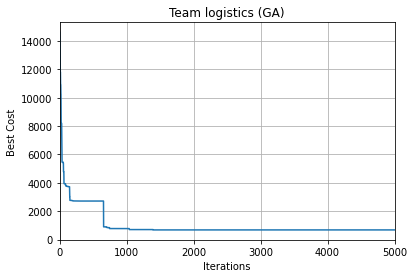

In [606]:
# Report results to screen
cost_function = get_costfunc(helicopter_capacities, teams, all_team_transports, distances, report=True)
print(cost_function(out.bestsol.position, True))
# Make a plot of the cost progression
plt.plot(out.bestcost)
plt.xlim(0, hyper_params["maxit"])
plt.xlabel('Iterations')
plt.ylabel('Best Cost')
plt.title('Team logistics (GA)')
plt.grid(True)
plt.show()

[13106   101  1101  5105 13209  4108  4203  5201   202  1206]
[ 9106  9201 12105  7109 12200 15100  7201 15209]
[14107  6103  6204  3106 14205  3209]
[ 2107 10109  2208  8107 10200  8208]
[[  101   202]
 [ 1101  1206]
 [ 2107  2208]
 [ 3106  3209]
 [ 4108  4203]
 [ 5105  5201]
 [ 6103  6204]
 [ 7109  7201]
 [ 8107  8208]
 [ 9106  9201]
 [10109 10200]
 [12105 12200]
 [13106 13209]
 [14107 14205]
 [15100 15209]]


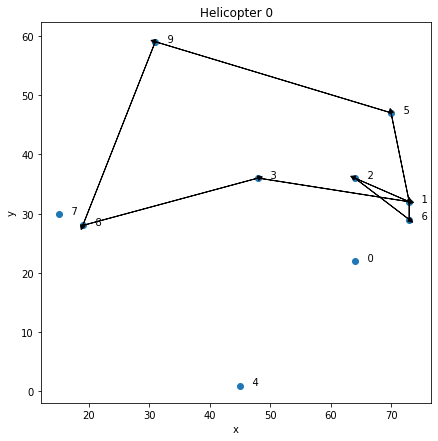

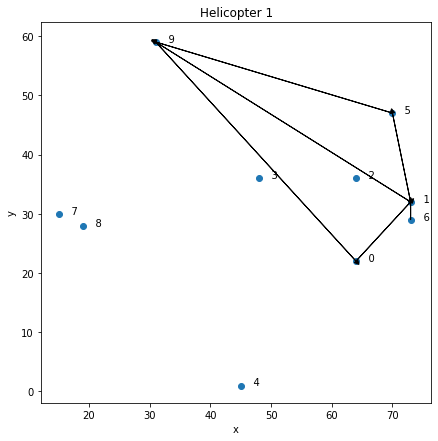

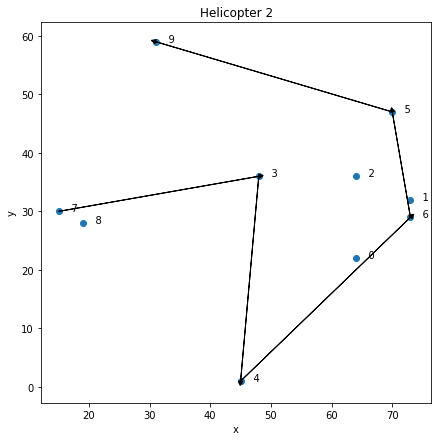

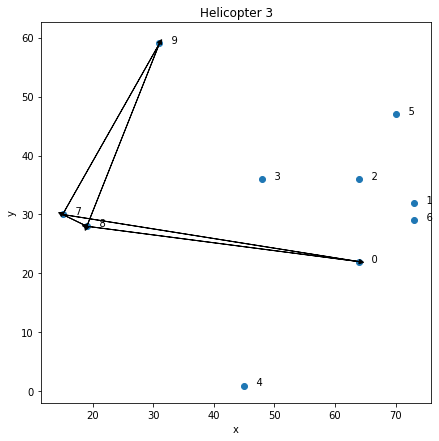

In [603]:
def plot_routes(platforms, route, title):
        fig, ax = plt.subplots()
        fig.set_figheight(7)
        fig.set_figwidth(7)
        ax.set_title(title)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        x = platforms[:,0]
        y = platforms[:,1]
        ax.scatter(x, y)
        for i in range(len(x)):
            ax.annotate(f"    {i}", (x[i], y[i]))
        
        if len(route) > 0:
            sx, sy = platforms[route[0]%100,0], platforms[route[0]%100,1]
            for platform in route[1:]:
                x,y = platforms[platform%100,0], platforms[platform%100,1]
                if sx == x and sy == y: continue
                ax.arrow(sx,sy,x-sx,y-sy, head_width=.75, head_length=.75, width=.001, fc='k', ec='k')
                sx, sy = x, y
            
routes = extract_routes(out.bestsol.position, n_helicopters)

for route in routes:
    print(route)

print(team_transports)
    
for h in range(n_helicopters):
    plot_routes(platforms, routes[h], f"Helicopter {h}")

## Fin

In [470]:
np.cumsum([1,2,3,4])

array([ 1,  3,  6, 10])